# Overfitting and regularization
- COMP 1801 IT lab: 23 Oct 2020
$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$
## Aim
- Learn how we can avoid overfitting by regularization 
## Note: to execute a cell, press SHIFT + ENTER

## Import libraries
- Numpy: for vectors, matrices
- Tensorflow: for automatic differentiation

In [1]:
import numpy as np # import numpy and set "np" as the alias of the numpy
import tensorflow as tf # import tensorflow and set "tf" as the alias of the tensorflow

## Variable and constant
### Defining a "variable" (a variable with respect to which we will calculate the derivative.)
- $\texttt{tf.Variable(value, dtype=np.float32)}$
  - $\texttt{value}$ can be a python list, numpy array, or tensorflow Tensor, and will be regarded as the initial value.

### Defining a "constant" (a variable for which we do not need to calculate the derivative)
- $\texttt{tf.constant(value, dtype=np.float32)}$
  - $\texttt{value}$ is the value of the "constant Tensor"
  - Strictly speaking, the "Tensor" defined by this is immutable, so not "constant."

### Mathematical functions
- Operators are similar to those in Numpy
  - $\texttt{+, -, *, /}$: elementwise addition, subtraction, multiplication, division
  - $\texttt{@}$: matrix product
- Most mathmatical function can be given by replacing np of a Numpy function by tf.math
  - $\texttt{np.sin(x), np.cos(x), np.exp(x)} \to \texttt{tf.math.sin(x), tf.math.cos(x), tf.math.exp(x)}$

## Automatic differentiation
- Define the Variables (e.g. $\texttt{th}$) and constants
- Define return value (e.g. $\texttt{j}$) in $\texttt{tf.GradientTape() as tape:} block$
- Get the gradient by $\texttt{tape.gradient()}$ (e.g. $\texttt{tape.gradient(j, th)}$)

## Load the data for linear regression

In [2]:
from sklearn.datasets import load_boston, load_breast_cancer, fetch_california_housing
dataset = fetch_california_housing()
# print(dataset.DESCR)
# print(dataset.feature_names)
raw_X_all = dataset.data # get feature data
y = dataset.target # get target data as a size-m 1-d array
np_Y_all = y[:, np.newaxis] # convert the target data to a m x 1 2-d array

## Data splitting

In [3]:
n_trains = 60
n_vals = 10
n_tests = 10
raw_X_train = raw_X_all[:n_trains]
raw_X_val = raw_X_all[n_trains:n_trains+n_vals]
raw_X_test = raw_X_all[n_trains+n_vals:n_trains+n_vals+n_tests]
np_Y_train = np_Y_all[:n_trains]
np_Y_val = np_Y_all[n_trains:n_trains+n_vals]
np_Y_test = np_Y_all[n_trains+n_vals:n_trains+n_vals+n_tests]
n = raw_X_all.shape[1]

## Data preprocessing

In [4]:
def standardise(raw_X, mu=None, sigma=None):
  if mu is None:
    mu = np.mean(raw_X, axis=0, keepdims=True)
  if sigma is None:
    sigma = np.std(raw_X, axis=0, keepdims=True)
  X_standardised = (raw_X - mu) / sigma  # Broadcasting is used here
  return X_standardised, mu, sigma

def append_one_to(X_without_one):
  X_with_one = np.pad(X_without_one, ((0, 0), (1, 0)), constant_values=1)
  return X_with_one

np_X_train_wo_one, mean_train, std_train = standardise(raw_X_train)
np_X_val_wo_one, _, _ = standardise(raw_X_val, mean_train, std_train)
np_X_test_wo_one, _, _ = standardise(raw_X_test, mean_train, std_train)
np_X_train = append_one_to(np_X_train_wo_one)
np_X_val = append_one_to(np_X_val_wo_one)
np_X_test = append_one_to(np_X_test_wo_one)


## Mean squared error with regularization
$$J(\Vec{\theta}; \Mat{X}, \Vec{y}) = \frac{1}{2} \times \left[ \frac{1}{m} \sum_{i=0}^{m-1} ([\Mat{X}]_{i, *} \Vec{\theta} - [\Vec{y}]_{i})^2 + \frac{\lambda}{m} \sum_{j=1}^{n} (\theta_{j})^{2} \right] = \frac{1}{2 m}\left[(\Mat{X} \Vec{\theta} - \Vec{y})^\top (\Mat{X} \Vec{\theta} - \Vec{y}) + \lambda \Vec{\theta}_{1:}^\top \Vec{\theta}_{1:} \right]$$

Let's implement the mean squared error in the following cell!


In [5]:
def j_func(th, X, Y, lamb):
  m, n = X.shape
  prediction = X @ th
  j = (1/(2 * m)) * ((tf.transpose(prediction - Y) @ (prediction - Y)) + lamb * (tf.transpose(th[1:, :]) @ th[1:, :]))
  j = tf.squeeze(j)
  return j


## Definition of a function for training using tensorflow

In [6]:
X_train = tf.constant(np_X_train, dtype=np.float32)
Y_train = tf.constant(np_Y_train, dtype=np.float32)
X_val = tf.constant(np_X_val, dtype=np.float32)
Y_val = tf.constant(np_Y_val, dtype=np.float32)
X_test = tf.constant(np_X_test, dtype=np.float32)
Y_test = tf.constant(np_Y_test, dtype=np.float32)

learning_rate = 0.01
momentum = 0.1
optimizer = tf.optimizers.SGD(learning_rate, momentum=momentum)
n_steps = 2000
display_interval = 500

def train(lamb):
  print('regularisation parameter lambda =', lamb)
  th = tf.Variable(tf.random.normal([n+1, 1], dtype=np.float32))
  for i_step in range(n_steps): 
    with tf.GradientTape() as tape:
      j = j_func(th, X_train, Y_train, lamb)

    dj_dth = tape.gradient(j, th)

    optimizer.apply_gradients(zip([dj_dth], [th])) # update using gradient

    if i_step % display_interval == 0:
      print('j', j.numpy())
      # print('th', th.numpy())
      # print('dj/dth', dj_dth.numpy())

  tf_mse_train = j_func(th, X_train, Y_train, 0.0) # set lamb=0.0, because we evaluate the loss
  mse_train = tf_mse_train.numpy()
  print('mse on training data', mse_train)

  tf_mse_val = j_func(th, X_val, Y_val, 0.0) # set lamb=0.0, because we evaluate the loss
  mse_val = tf_mse_val.numpy()
  print('mse on validation data', mse_val)

  tf_mse_test = j_func(th, X_test, Y_test, 0.0) # set lamb=0.0, because we evaluate the loss
  mse_test = tf_mse_test.numpy()
  return mse_train, mse_val, mse_test


## Set regularization parameters and training (You can modify the code here)

In [7]:
# Change regularization parameter list
# Edit the code: start
import time
tic = time.perf_counter()
regularization_parameter_list = [500.0, 250.0, 100.0, 10.0, 0.1, 0.01]
# Edit the code: end
results = np.array([train(lamb) for lamb in regularization_parameter_list]).T
toc = time.perf_counter()
print(f"Training time: {toc - tic:0.4f} seconds")

regularisation parameter lambda = 500.0
j 47.465244
j 0.2680454
j 0.26799703
j 0.26799703
mse on training data 0.21589416
mse on validation data 0.15906085
regularisation parameter lambda = 250.0
j 23.72811
j 0.2262264
j 0.22621839
j 0.22621843
mse on training data 0.15913972
mse on validation data 0.09173491
regularisation parameter lambda = 100.0
j 17.717587
j 0.16259801
j 0.1625852
j 0.1625852
mse on training data 0.09512306
mse on validation data 0.05239768
regularisation parameter lambda = 10.0
j 11.273794
j 0.067421824
j 0.064180836
j 0.06396924
mse on training data 0.044956278
mse on validation data 0.1558385
regularisation parameter lambda = 0.1
j 11.961056
j 0.05774883
j 0.048213676
j 0.04507931
mse on training data 0.043483663
mse on validation data 0.25678322
regularisation parameter lambda = 0.01
j 4.8197117
j 0.054048017
j 0.04726365
j 0.044595167
mse on training data 0.043400966
mse on validation data 0.22740638
Training time: 16.8601 seconds


## Plot the training error and validation error

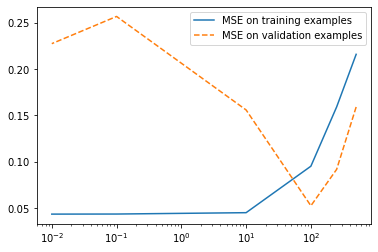

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.xscale('log')
plt.plot(regularization_parameter_list, results[0], '-', label = 'MSE on training examples')
plt.plot(regularization_parameter_list, results[1], '--', label = 'MSE on validation examples');
plt.legend()

## Test the performance on the test examples

In [9]:
best_lambda_index = np.argmin(results[1])
best_lambda = regularization_parameter_list[best_lambda_index]
mse_test_by_best_lambda = results[2][best_lambda_index]
print('best lambda =', best_lambda, '\n', 'test mse =', mse_test_by_best_lambda)

best lambda = 100.0 
 test mse = 0.04447801


# Submission

In [10]:
# --- Edit the following information ---
your_email_address = 'mb5878n@gre.ac.uk'
your_student_id = '001002629'
your_first_name = 'Michael'
your_last_name = 'Briggs'
# --- Edit the above information ---

# After filling the above information, execute this cell by pressing Shift + Enter

# --- Don't touch the below ---
# Execute after filling the above descriptions by pressing Shift + Enter
!pip install pycryptodome
import urllib.request
from bs4 import BeautifulSoup
import requests, warnings
import json
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP

submission_id = 'comp-1801_20201023-01'
student_information = dict(email=your_email_address, id=your_student_id, first_name=your_first_name, last_name=your_last_name)
answer = dict(best_lambda=str(best_lambda), best_mse=str(results[2][best_lambda_index]))
submission_dict = dict(submission_id=submission_id, student_information=student_information, answer=answer)
submission_json = json.dumps(submission_dict)

def get_questions(in_url):
    res = urllib.request.urlopen(in_url)
    soup = BeautifulSoup(res.read(), 'html.parser')
    get_names = lambda f: [v for k,v in f.attrs.items() if 'label' in k]
    get_name = lambda f: get_names(f)[0] if len(get_names(f))>0 else 'unknown'
    all_questions = soup.form.findChildren(attrs={'name': lambda x: x and x.startswith('entry.')})
    return {get_name(q): q['name'] for q in all_questions}

def submit_response(form_url, cur_questions, verbose=False, **answers):
    submit_url = form_url.replace('/viewform', '/formResponse')
    form_data = {'draftResponse':[],
                'pageHistory':0}
    for v in cur_questions.values():
        form_data[v] = ''
    for k, v in answers.items():
        if k in cur_questions:
            form_data[cur_questions[k]] = v
        else:
            warnings.warn('Unknown Question: {}'.format(k), RuntimeWarning)
    if verbose:
        print(form_data)
    user_agent = {'Referer':form_url,
                  'User-Agent': "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.52 Safari/537.36"}
    return requests.post(submit_url, data=form_data, headers=user_agent)


FORM_URL = "https://docs.google.com/forms/d/e/1FAIpQLScNs3Cf6DnNCBCUyPGfp22mI3FYVBfTNbGi0TxZ0_SKo9fgCw/viewform"
anno_questions = get_questions(FORM_URL)
public_key_utf = '''-----BEGIN PUBLIC KEY-----
MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAp/lFj1VO6DQ+Ot27oamm
KImRJiXz7IlhdlfkAmytONDQAtvgp9/AqfHyIA0+YnaTDGditMK4t1u6s2YvYlW8
5tKbAkbziDAOyaxkepwEw47ldco3hh8p+N42nymWZJp7GKwaHUJ/k1S5sTzFso9o
8/szKGlHUq3lpQdQeWScAirCvCewqJFrJWiLymoS0IbeeCzxCJxqmLwx4kXjCTeU
c9yUqCi+dZ41Cebd8z5y4Ekf58JP+jh/B0VPHV5cR2D/S3zrhWjPnSU4nCKef5pE
b863LlyJ1/sKheanBTq7+9rxMf2rNrsH8Nea4UW2gwtPgOogWFdiWgKYl7B1ks7E
OQIDAQAB
-----END PUBLIC KEY-----'''

split_n = lambda text, n: [ text[i*n:i*n+n] for i in range(len(text)//n) ]
def split_n(string, length):
    return (string[0+i:length+i] for i in range(0, len(string), length))
answer_json_list = split_n(submission_json, 32)
cipher_rsa = PKCS1_OAEP.new(RSA.import_key(public_key_utf.encode('utf-8')))
encrypted_answer_json = '\n'.join([cipher_rsa.encrypt(line.encode()).hex() for line in answer_json_list])
submit_response(FORM_URL, {'answer': 'entry.1985698402'}, **{'answer': encrypted_answer_json})
print('Successfully submitted!!')
print('Check your information: ', ', '.join([': '.join([k, str(v)]) for k, v in student_information.items()]), '\n', 'Your answer: ', ', '.join([': '.join([k, str(v)]) for k, v in answer.items()]))


ModuleNotFoundError: No module named 'bs4'